# Brain tumor Detection and Segmentation with Mask R-CNN using MRIs.
#### Alexandre Lacour - Fares Sayadi

## What is a brain tumor?<a class="anchor" id="first-bullet"></a>

A brain tumor occurs when abnormal cells form in the brain.
There are two main types of tumors: 
* cancerous (malignant) tumors
* benign tumours.

Cancerous tumors can be divided into primary tumors, which originate in the brain, and secondary tumors, which have spread from another location, called metastatic brain tumors. 

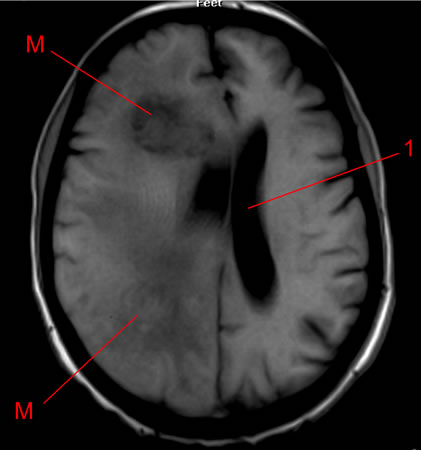

 Multiple brain metastases in a 27-year-old smoking patient with lung cancer.

## Mask R-CNN model<a class="anchor" id="second-bullet"></a>

- Mask R-CNN is a model that generates bounding boxes and segmentation masks for each instance of an object in an image. It is based on the Feature Pyramid Network (FPN) extractor and ResNet101.
- Mask R-CNN decouples mask and class prediction: it predicts a binary mask for each class independently, without competition between classes, and relies on the RoI (Region of Interest) of the classification branch of the network to predict the category. 
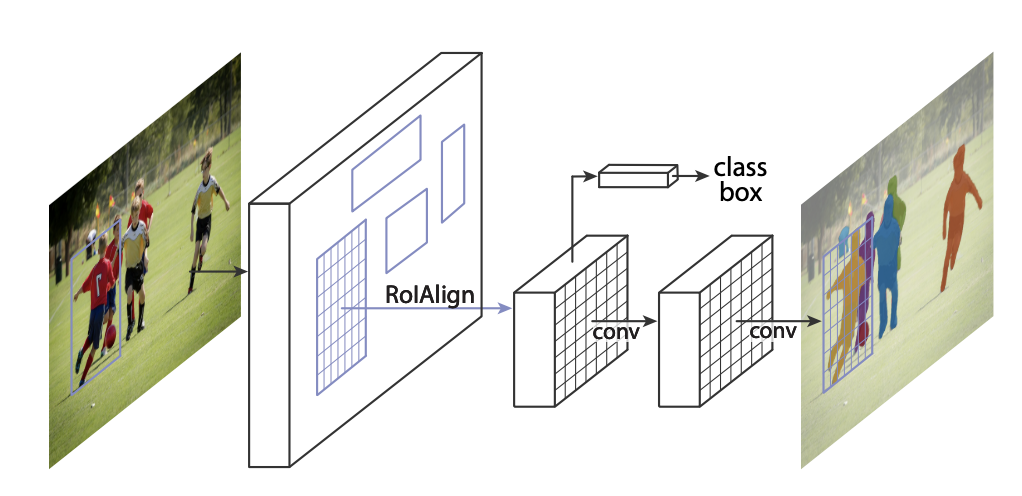

Mask R-CNN architecture

## Setting up the environment<a class="anchor" id="third-bullet"></a>

In [8]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

For this project, we used the following specifications and versions: 
* GPU : NVIDIA Geforce RTX 2060
* CUDA : 10
* tensorflow-gpu : 1.14
* keras : 2.2.5
* h5py : 2.10.0

In [14]:
# Testing for GPU
tf.test.is_gpu_available(
    cuda_only=True
)

True

In [17]:
# Importing libraries
import os
import re
import sys
import cv2
import glob 
import time
import json
import math
import random
import imutils
import itertools
import matplotlib
import numpy as np # linear algebra
import skimage.draw
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from tqdm import tqdm
import matplotlib.cm as cm
from skimage.io import imread
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
from imgaug import augmenters as iaa
import keras

from IPython.display import clear_output

!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation
!git clone https://github.com/rastislavkopal/brain-tumor-segmentation.git # load manually annotated data from git repo
# !git clone -b activation https://github.com/sumanpanda1997/image_segmentation    
    
!rm -rf brain-tumor-segmentation/.git/
!rm -rf Mask_RCNN/.git/

clear_output()

In [18]:
# Import libraries needed for Mask R-CNN 

# Root directory of the project
# ROOT_DIR = os.path.abspath("./image_segmentation")
ROOT_DIR = os.path.abspath("./Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_LOGS_DIR = 'logs' 

clear_output()

In [19]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Import COCO config  
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'

DATASET_DIR = './brain-tumor-segmentation/brain_tumor_data/'
    
clear_output()

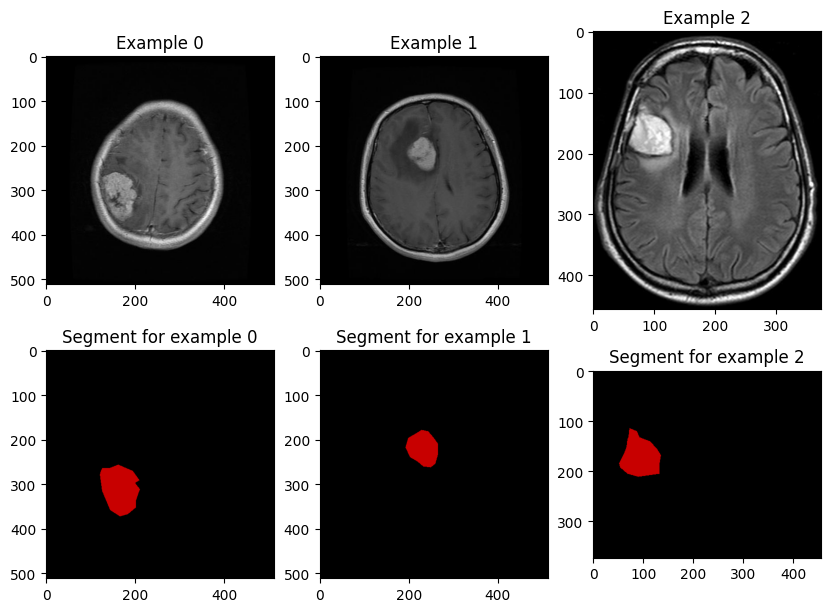

In [26]:
# We load a few images from the train directory of the dataset

examples = [Image.open(DATASET_DIR + 'train/271.jpg'),Image.open(DATASET_DIR + 'train/280.jpg'),Image.open(DATASET_DIR+'train/239.jpg')]
examplesSeg = ['271.jpg17751','280.jpg17413','239.jpg29545']

## print some example images from train directory
fig = plt.figure(figsize=(10,14))

for i in range(0, len(examples)):
    a = fig.add_subplot(1, 3, i+1)
    imgplot = plt.imshow(examples[i])
    a.set_title('Example '+str(i))

## print segment examples for images from json annotations file
with open(DATASET_DIR+'train/annotations.json') as json_file:
    data = json.load(json_file)
    for i in range(0,len(examplesSeg)):
        # load regions from json file and transform them into (x,y) coordinates
        coord = list(zip(data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_x'],data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_y'])) 
        image = Image.new("RGB", np.asarray(examples[i]).shape[0:2])
        draw = ImageDraw.Draw(image)
        draw.polygon((coord), fill=200)
        a = fig.add_subplot(2, 3, 3+i+1)
        imgplot = plt.imshow(image)
        a.set_title('Segment for example ' + str(i))

In [27]:
# Configurations
class BrainTumorConfig(Config):
    """Configuration for training on the brain tumor segmentation dataset.
    Derives from the base Config class and overrides values specific
    to the brain tumor segmentation dataset.
    """
    # Give the configuration a recognizable name
    NAME = "brain_tumor"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + brain tumor

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = BrainTumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [28]:
class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations'+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## Mask R-CNN Model<a class="anchor" id="fourth-bullet"></a>

In [31]:
warnings.filterwarnings('ignore')

# Create model
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

# Load weights
model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [32]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

# Test dataset
dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

In [ ]:
# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=15,
    layers='heads'
)

In [19]:
# We save the weights of the training
model.keras_model.save_weights('model-brain-tumor-gpu.h5')

In [63]:
warnings.filterwarnings('ignore')

# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
model_path = "model-brain-tumor-gpu.h5"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  model-brain-tumor-gpu.h5


## Tumor detection prediction<a class="anchor" id="fifth-bullet"></a>

In [102]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    if len(r['rois']):
        visualize.display_differences(
            original_image,
            gt_box, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            class_names = ['tumor'], title="", ax=get_ax(),
            show_mask=True, show_box=True)

In [103]:
# We display the original image without annotations first to visualize the differences
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

In [104]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Prediction visualization on test dataset

* Score is the probability of the class
* IoU is the intersection over union of the mask
* The higher the score, the higher the probability of the class
* The higher the IoU, the higher the overlap between the mask and the ground truth

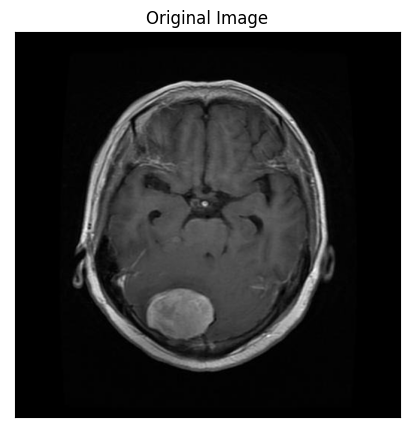

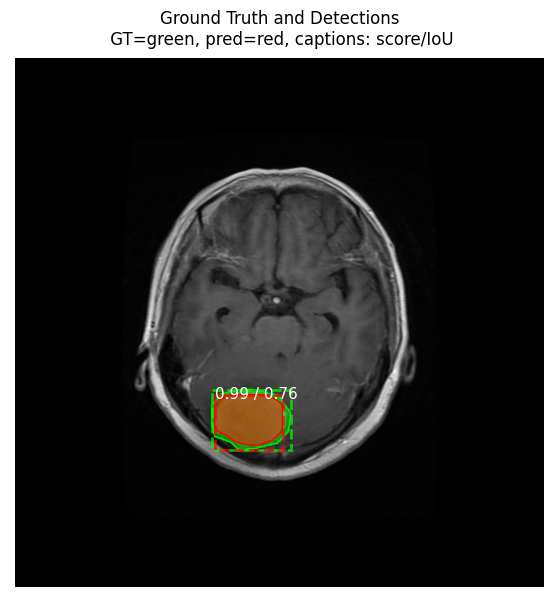

In [72]:
display_image(dataset_test, 6)
predict_and_plot_differences(dataset_test, 6)

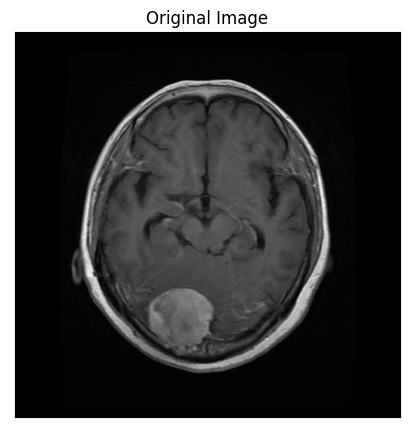

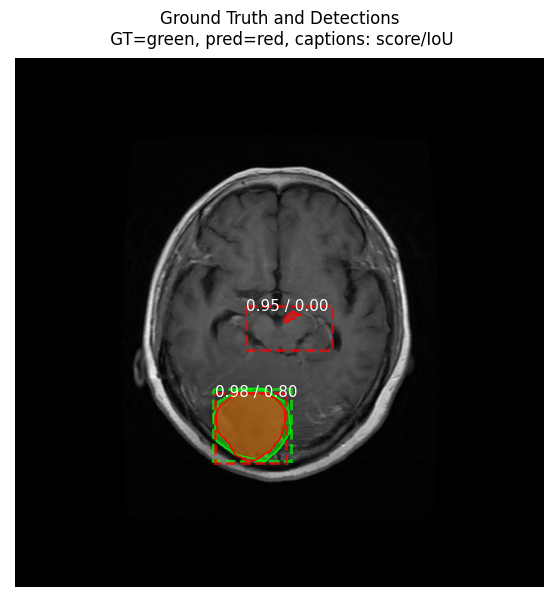

In [73]:
display_image(dataset_test, 8)
predict_and_plot_differences(dataset_test, 8)

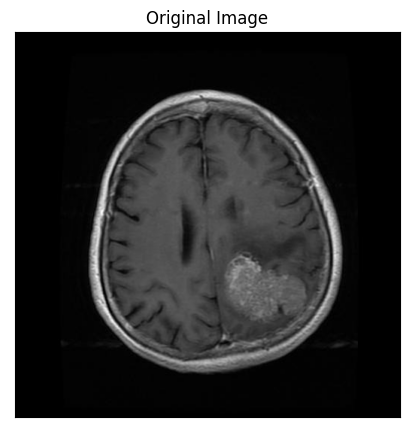

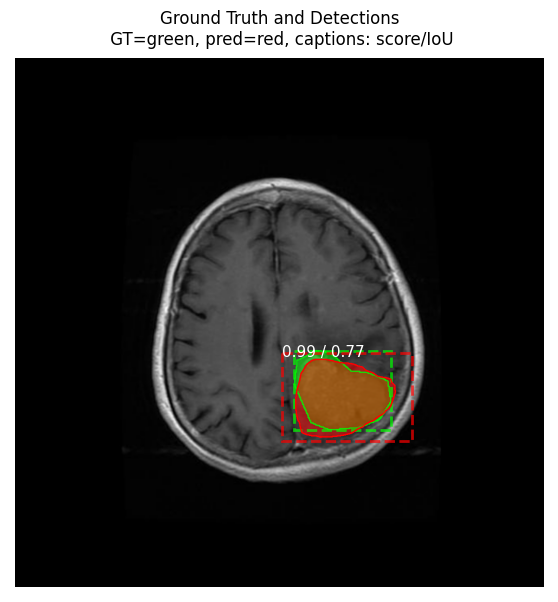

In [74]:
display_image(dataset_test, 23)
predict_and_plot_differences(dataset_test, 23)

## Performance metrics - Interpretations<a class="anchor" id="sixth-bullet"></a>

IoU is a common metric used in computer vision to evaluate the similarity of two masks or bounding boxes. It is defined as the area of overlap between the two masks divided by the area of their union. A value of 1 indicates that the two masks are identical, while a value of 0 indicates that the two masks do not overlap at all. IoU is often used as a performance metric for object detection and instance segmentation models.

In [89]:
# gt = ground truth (green zone) / predict = model prediction (red zone)
def get_iou(gt, pred):
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou_score = np.sum(intersection > 0) / np.sum(union > 0)
    return iou_score

In [91]:
# get some performance metrics
from sklearn.metrics import confusion_matrix, classification_report

# precision of the model 
# true positives / (true positives + false positives)
def get_precision(gt, pred):
    intersection = np.logical_and(gt, pred)
    precision = np.sum(intersection > 0) / np.sum(pred > 0)
    return precision

# recall of the model
# true positives / (true positives + false negatives)
def get_recall(gt, pred):
    intersection = np.logical_and(gt, pred)
    recall = np.sum(intersection > 0) / np.sum(gt > 0)
    return recall

# f1 score of the model
# 2 * (precision * recall) / (precision + recall)
def get_f1_score(gt, pred):
    precision = get_precision(gt, pred)
    recall = get_recall(gt, pred)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

# get precision, recall and f1 score of all images
precisions = []
recalls = []
f1_scores = []
ious = []
for img_id in dataset_test.image_ids:
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset_test, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    precision = get_precision(gt_mask, r['masks'])
    recall = get_recall(gt_mask, r['masks'])
    f1_score = get_f1_score(gt_mask, r['masks'])
    iou = get_iou(gt_mask, r['masks'])
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    ious.append(iou)
    
    #remove nan
precisions = [precision for precision in precisions if not np.isnan(precision)]
recalls = [recall for recall in recalls if not np.isnan(recall)]
f1_scores = [f1_score for f1_score in f1_scores if not np.isnan(f1_score)]
ious = [iou for iou in ious if not np.isnan(iou)]

In [92]:
# Printing performance metrics
print('Mean Precision: ', np.mean(precisions))
print('Mean Recall: ', np.mean(recalls))
print('Mean F1 Score: ', np.mean(f1_scores))
print('Mean IoU: ', np.mean(ious))

Mean Precision:  0.7333959593449857
Mean Recall:  0.4960805437299206
Mean F1 Score:  0.6275687339969712
Mean IoU:  0.3864362675057387


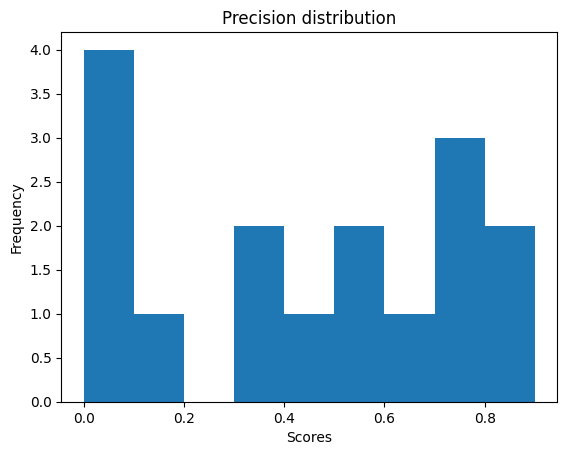

In [101]:
def hist_metric(name, metrics, nb_bins=10):
  bins = np.arange(0, 100, nb_bins)/100
  plt.hist(metrics, bins)
  plt.title(name + " distribution")
  plt.xlabel("Scores")
  plt.ylabel("Frequency")
  plt.show()

hist_metric('Precision', precisions, 10)

In [106]:
# Some IoUs = 0, we display all images to understand why
#for img_id in dataset_test.image_ids:
    #predict_and_plot_differences(dataset_test, img_id)

In [146]:
def display_top_masks_pred(image,image_id, mask, class_ids, class_names, predict_mask, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("MRI " + str(image_id))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append('Ground Truth')
    
    predict_mask = np.sum(predict_mask * np.arange(1, predict_mask.shape[-1] + 1), -1)
    to_display.append(predict_mask)
    titles.append("Predict")

    visualize.display_images(to_display, titles=titles, cols=limit + 3, cmap="Blues_r")

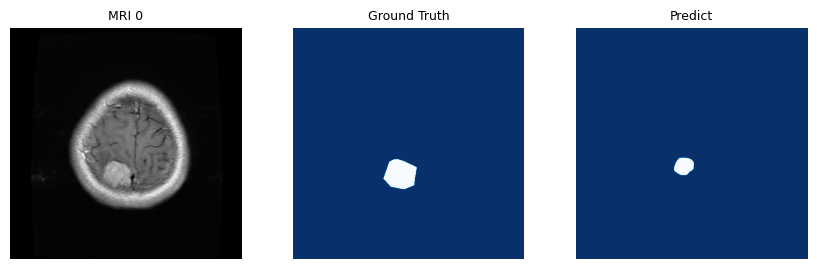

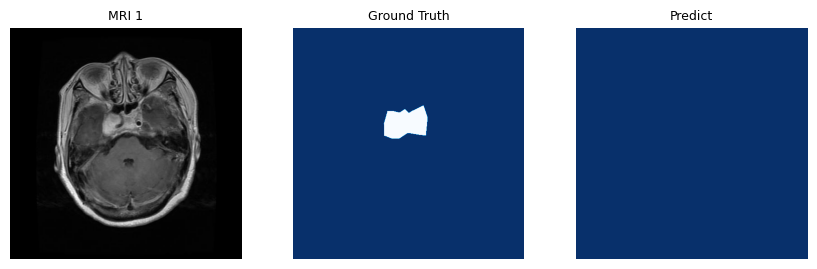

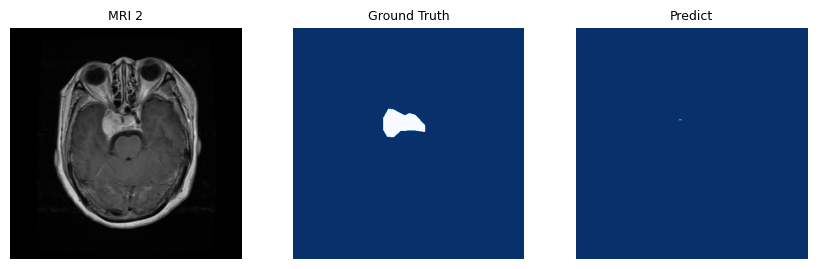

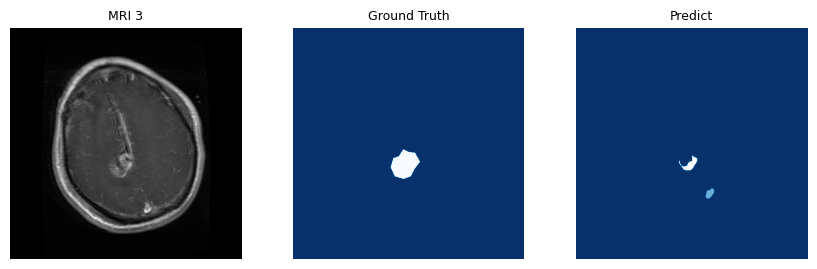

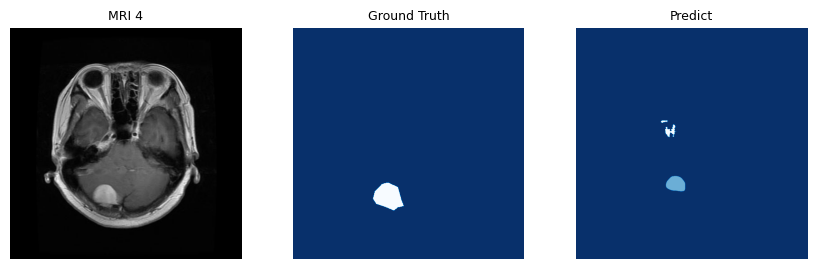

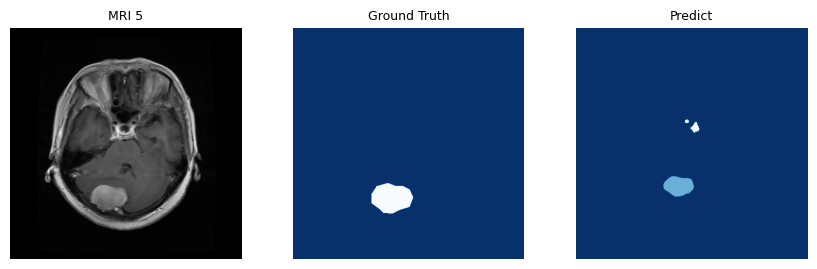

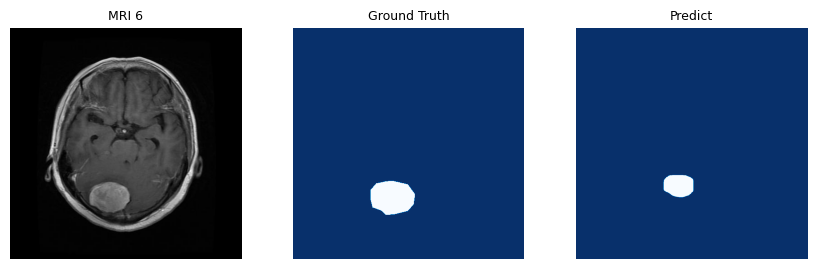

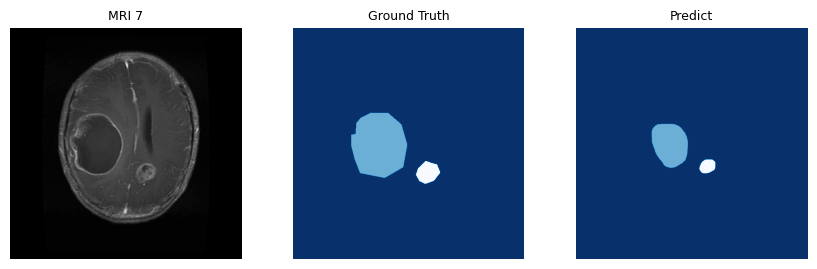

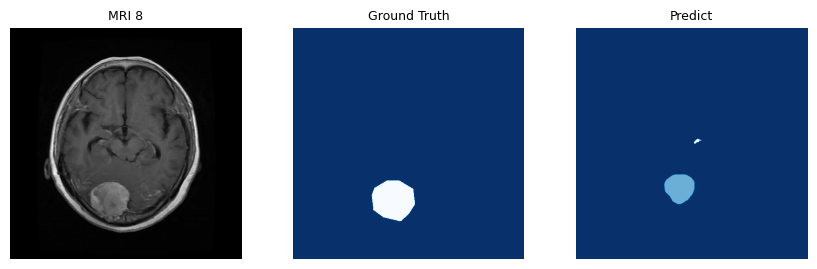

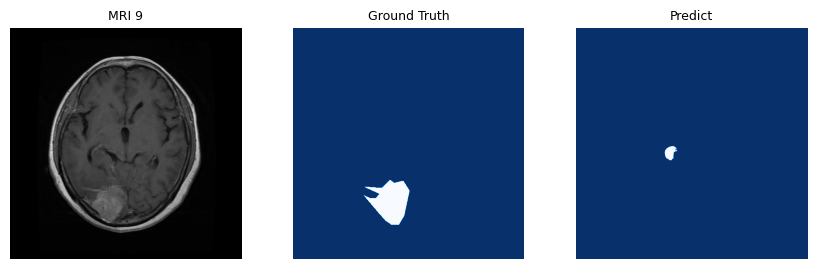

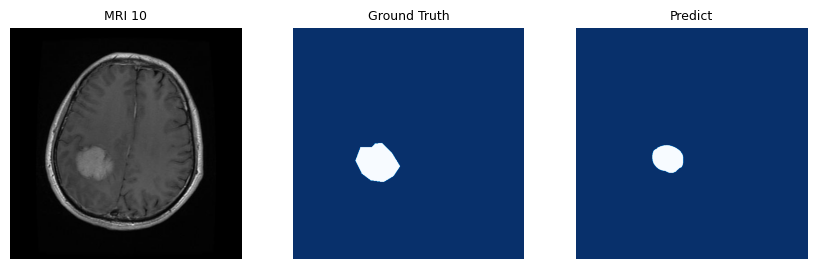

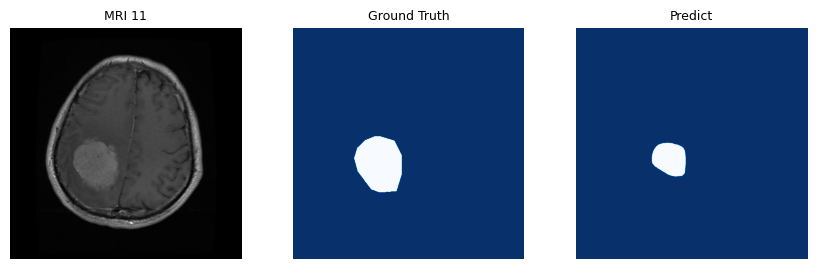

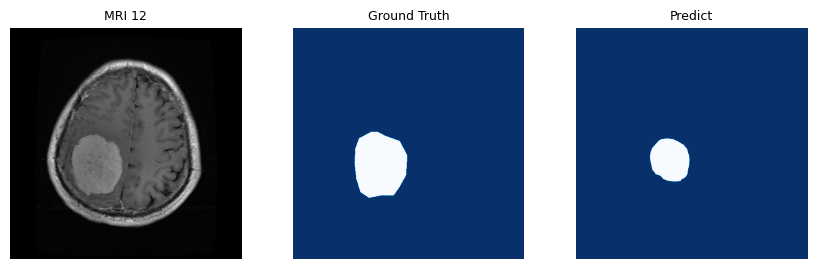

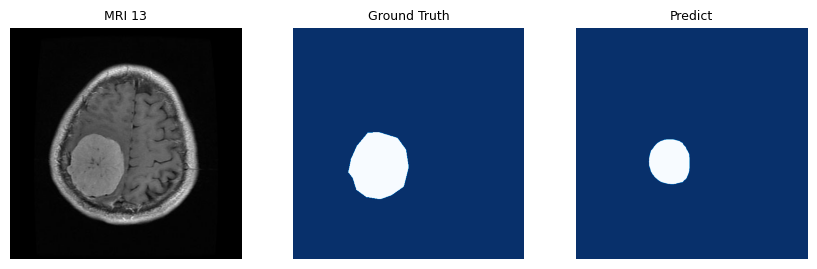

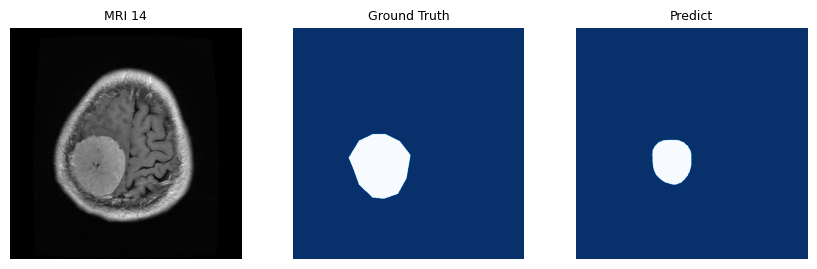

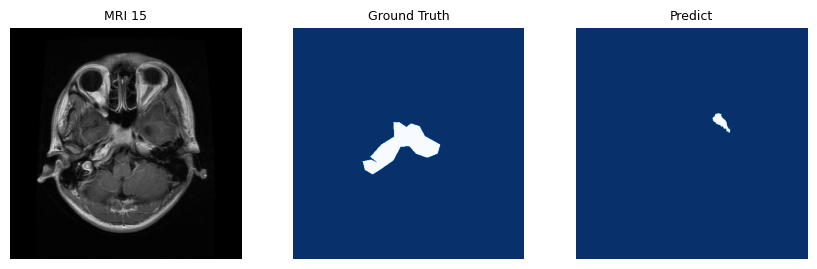

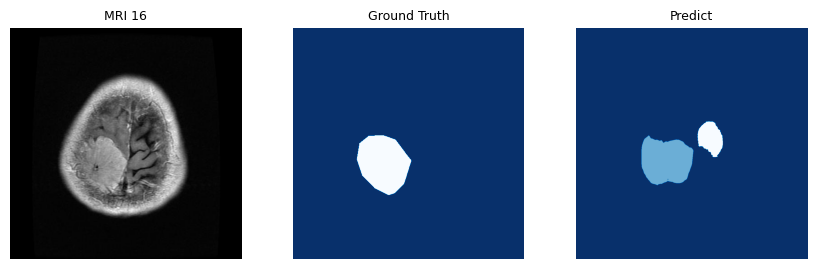

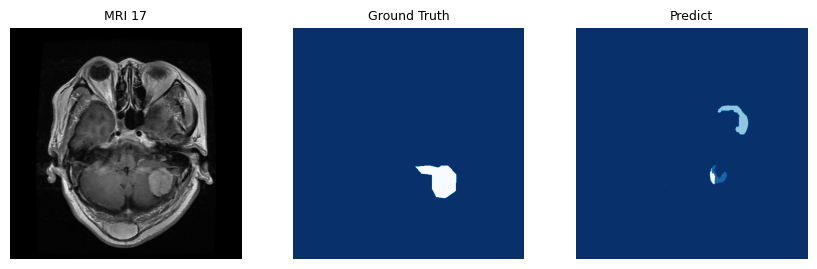

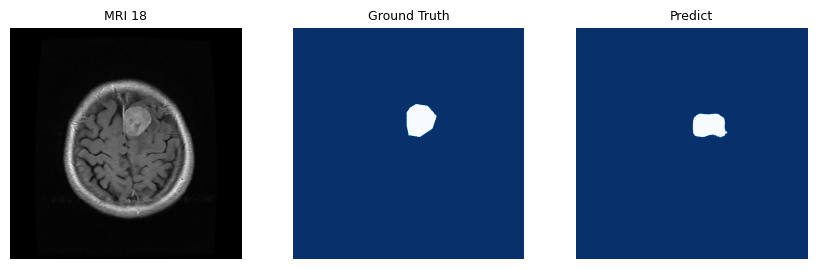

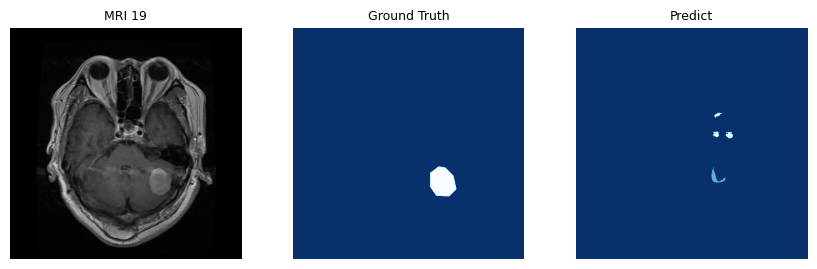

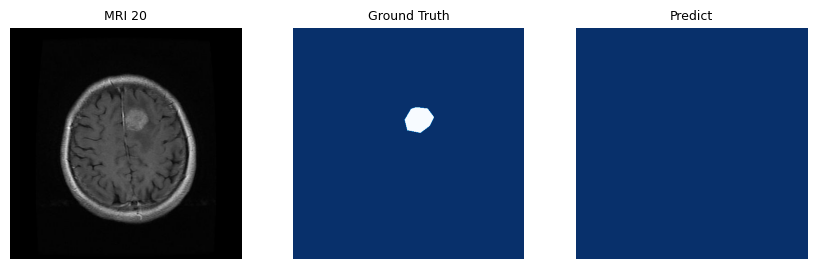

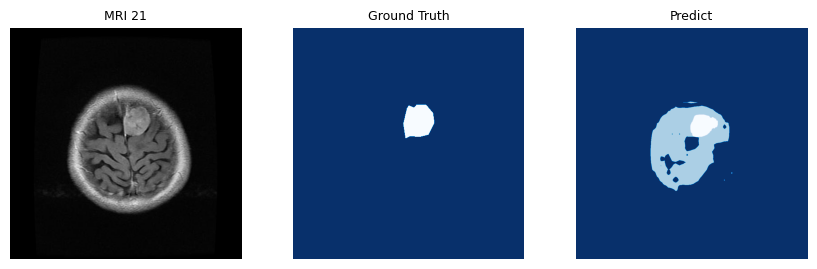

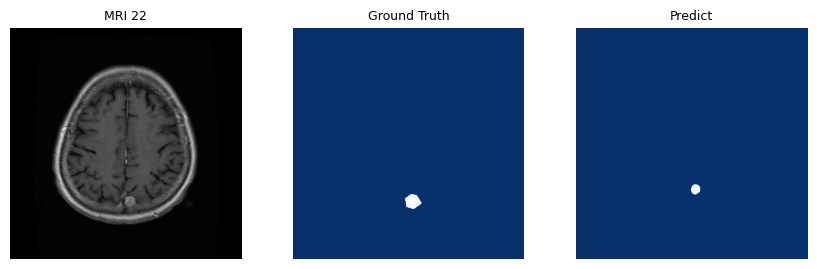

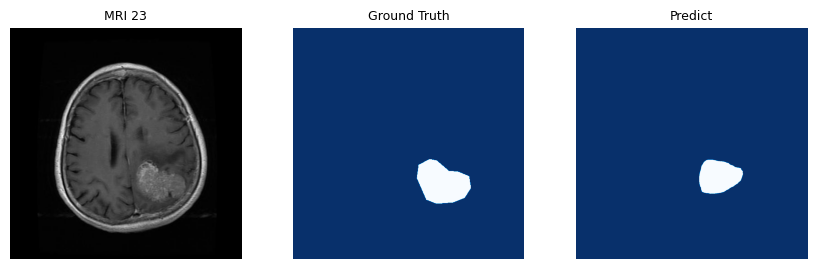

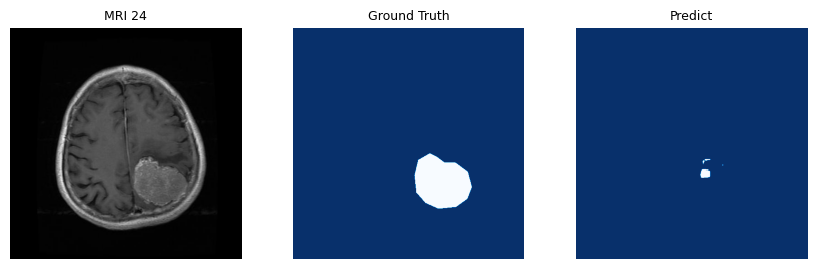

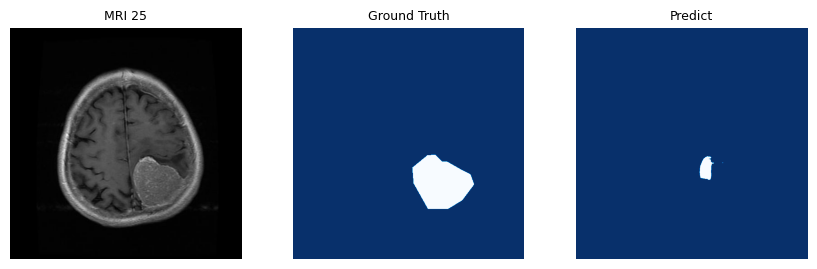

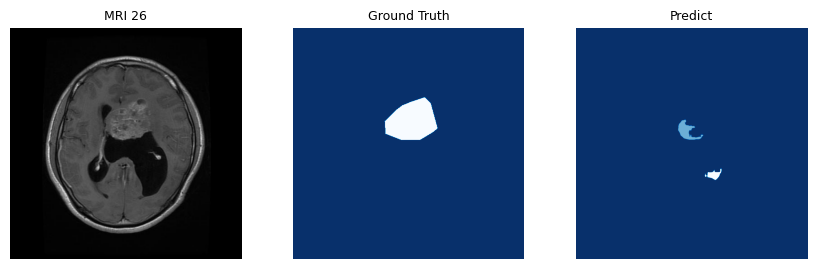

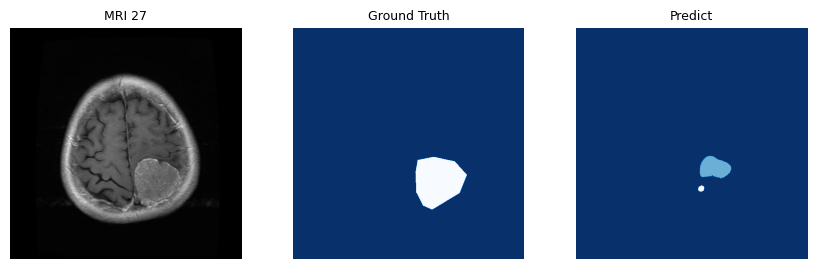

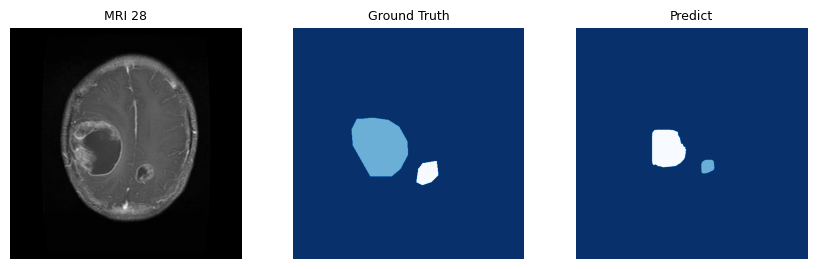

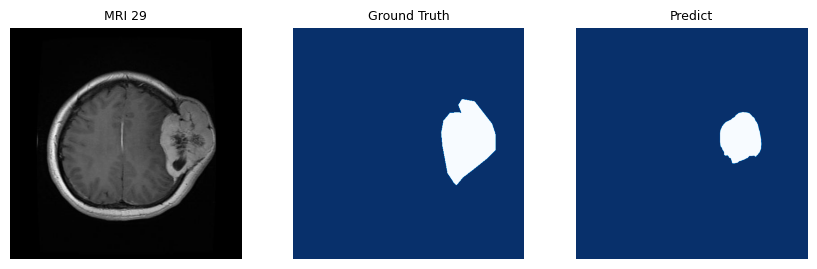

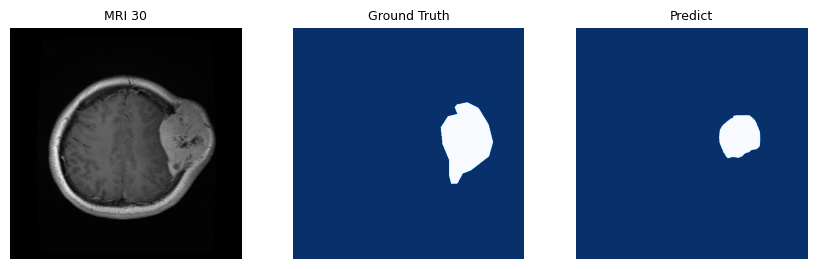

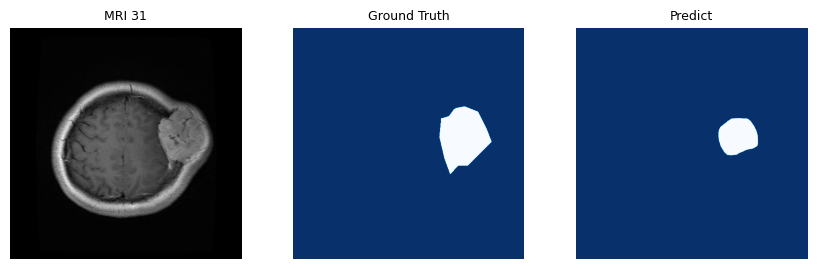

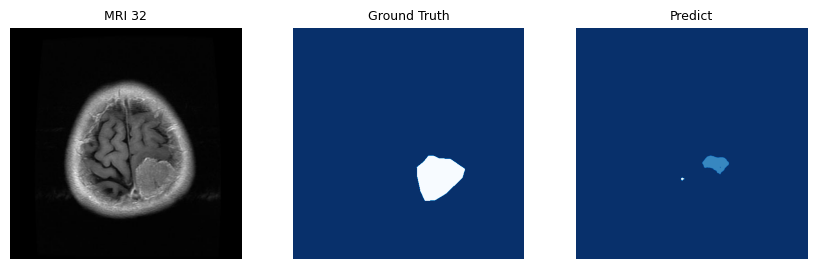

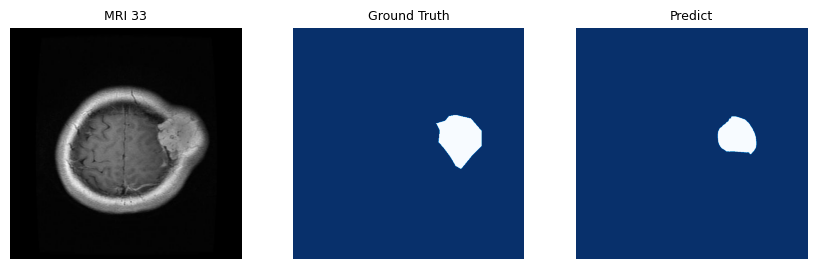

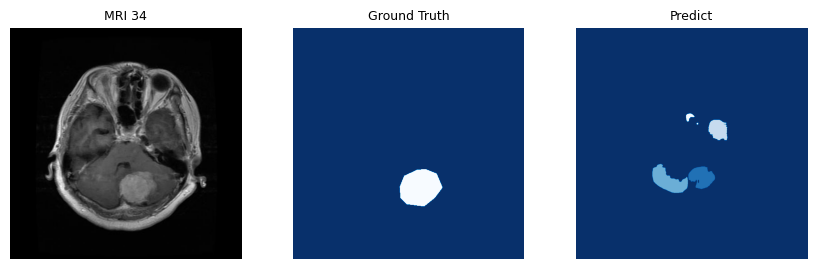

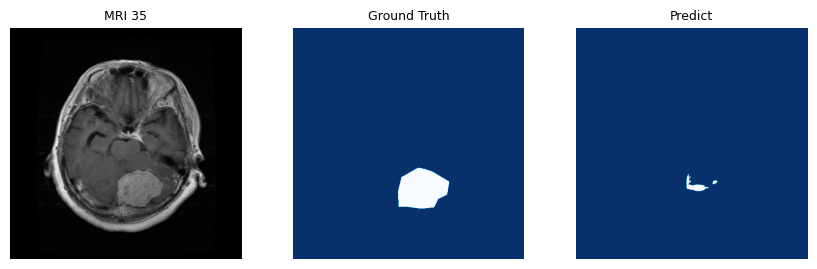

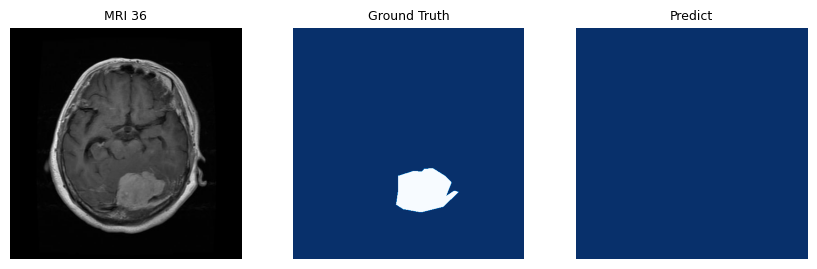

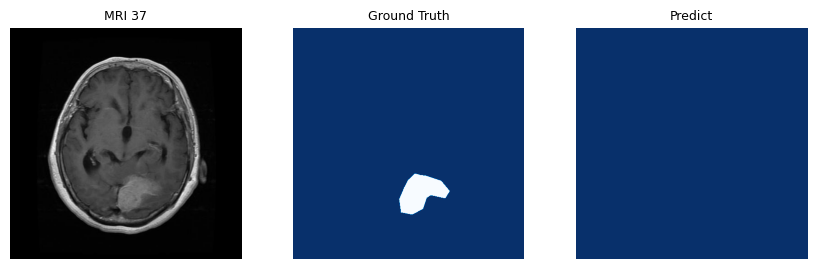

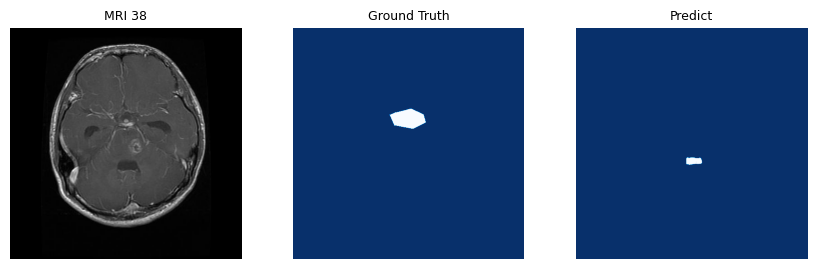

In [148]:
# We show the original MRI, the ground truth mask and the predict mask
for image_id in dataset_test.image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset_test, config, 
                               image_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    display_top_masks_pred(image, image_id, mask, class_ids, dataset_test.class_names, results[0]['masks'], limit=1)
